In [1]:
%load_ext jupyter_black

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv  # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import pairwise
from sklearn.model_selection import train_test_split
from typing import List
from flask import Flask, redirect, request
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D  # new
from tensorflow.keras.layers import MaxPooling2D  # new
from tensorflow.keras.layers import Flatten  # new
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize


pd.set_option("display.max_rows", None)  # pandas dataframe formatting options
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format


custom_env_path = "../../brainstation_capstone_cfg.env"  # environment variables file

## Sam's Clustering Example

In [3]:
test = pd.read_parquet(
    "../data/vectorized_mp3s/pairwise_complete_parquets/20230831_complete_vectorized_data.parquet"
)
test.head()

0    1    2    3    4    5    6    7    8    9   10  \
track_id                                                                        
6DQzmTJnaZw4A9IynCGfrM 0.45 0.43 0.53 0.59 0.45 0.39 0.38 0.47 0.44 0.44 0.58   
1Bk00Y8bvqKHzUTDfEH2RH 0.53 0.50 0.53 0.54 0.60 0.53 0.58 0.50 0.55 0.60 0.53   
7x8MCsillTMQGAStE4dmW8 0.38 0.51 0.40 0.45 0.37 0.48 0.50 0.42 0.52 0.36 0.39   
11uz9XML4cezgIT4LO9Zq7 0.56 0.49 0.64 0.45 0.36 0.40 0.47 0.37 0.32 0.44 0.60   
63eqAbSLuqUQiT8wDOMWLF 0.48 0.38 0.42 0.41 0.32 0.37 0.37 0.45 0.44 0.36 0.39   

                         11   12   13   14   15   16   17   18   19   20   21  \
track_id                                                                        
6DQzmTJnaZw4A9IynCGfrM 0.43 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
1Bk00Y8bvqKHzUTDfEH2RH 0.60 0.01 0.01 0.03 0.02 0.02 0.03 0.03 0.02 0.02 0.02   
7x8MCsillTMQGAStE4dmW8 0.32 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
11uz9XML4cezgIT4LO9Zq7 0.79 0.01 0.01 0.01 0.01 0.00 0.00 0.01 0.00 0.01 0.01   
63eqAbSLuqUQiT8wDOMWLF 0.41 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.01 0.00 0.01   

                         22   23   24   25   26   27   28   29   30   31   32  \
track_id                                                                        
6DQzmTJnaZw4A9IynCGfrM 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
1Bk00Y8bvqKHzUTDfEH2RH 0.02 0.02 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
7x8MCsillTMQGAStE4dmW8 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
11uz9XML4cezgIT4LO9Zq7 0.01 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
63eqAbSLuqUQiT8wDOMWLF 0.01 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   

                         33   34   35     36     37     38     39     40  \
track_id                                                                   
6DQzmTJnaZw4A9IynCGfrM 1.00 1.00 1.00 -28.97 -21.39 -19.32 -21.35 -21.52   
1Bk00Y8bvqKHzUTDfEH2RH 1.00 1.00 1.00 -26.44 -20.35 -16.74 -16.07 -16.00   
7x8MCsillTMQGAStE4dmW8 1.00 1.00 1.00 -27.70 -25.56 -27.49 -30.54 -27.80   
11uz9XML4cezgIT4LO9Zq7 1.00 1.00 1.00 -35.88 -31.71 -28.82 -30.74 -28.59   
63eqAbSLuqUQiT8wDOMWLF 1.00 1.00 1.00 -39.54 -33.37 -29.57 -32.60 -33.89   

                           41     42     43     44     45     46     47  \
track_id                                                                  
6DQzmTJnaZw4A9IynCGfrM -23.20 -24.18 -25.29 -24.75 -24.15 -26.99 -28.73   
1Bk00Y8bvqKHzUTDfEH2RH -17.77 -20.16 -20.40 -21.10 -20.19 -20.92 -24.13   
7x8MCsillTMQGAStE4dmW8 -24.23 -24.95 -24.89 -24.67 -29.23 -26.75 -25.04   
11uz9XML4cezgIT4LO9Zq7 -27.50 -28.46 -27.55 -33.10 -35.88 -34.54 -36.27   
63eqAbSLuqUQiT8wDOMWLF -31.59 -29.26 -25.66 -26.17 -27.83 -26.28 -25.23   

                           48     49     50     51     52     53     54  \
track_id                                                                  
6DQzmTJnaZw4A9IynCGfrM -28.78 -28.23 -28.24 -30.09 -29.61 -30.58 -26.84   
1Bk00Y8bvqKHzUTDfEH2RH -24.47 -23.97 -23.81 -24.07 -27.29 -29.49 -29.77   
7x8MCsillTMQGAStE4dmW8 -28.16 -28.96 -31.40 -34.18 -28.97 -29.09 -30.56   
11uz9XML4cezgIT4LO9Zq7 -37.92 -31.77 -28.85 -29.49 -34.96 -35.12 -35.54   
63eqAbSLuqUQiT8wDOMWLF -25.34 -26.19 -27.52 -27.48 -27.95 -30.56 -29.14   

                           55     56     57     58     59     60     61  \
track_id                                                                  
6DQzmTJnaZw4A9IynCGfrM -24.89 -29.86 -28.54 -27.32 -27.29 -25.98 -27.82   
1Bk00Y8bvqKHzUTDfEH2RH -32.03 -33.62 -32.67 -27.36 -27.29 -29.87 -29.15   
7x8MCsillTMQGAStE4dmW8 -30.05 -33.72 -32.03 -29.19 -32.67 -34.15 -28.43   
11uz9XML4cezgIT4LO9Zq7 -42.98 -56.16 -53.04 -45.79 -49.48 -57.19 -53.01   
63eqAbSLuqUQiT8wDOMWLF -28.59 -32.61 -31.77 -31.39 -31.87 -29.97 -30.55   

                           62     63     64     65     66     67     68  \
track_id                                                                  
6DQzmTJnaZw4A9IynCGfrM -30.40 -29.79 -25.38 -24.87 -28.49 -30

In [20]:
# test

In [4]:
from sklearn.cluster import KMeans

In [5]:
# clluster
# ideally use elbow method
kmeans = KMeans(n_clusters=3)
res = kmeans.fit_predict(test)

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
# test
cluster = kmeans.predict(test.sample(1))
cluster

array([1], dtype=int32)

In [15]:
# analize
pd.DataFrame(res).value_counts(ascending=False)
test["cluster"] = res

In [21]:
test.head(1000)[test["cluster"] == 0].head(10)

/var/folders/zn/5cb91d2d665dhj_s18vtzbpc0000gn/T/ipykernel_9956/2027110746.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test.head(1000)[test["cluster"] == 0].head(10)


0    1    2    3    4    5    6    7    8    9   10  \
track_id                                                                        
1Bk00Y8bvqKHzUTDfEH2RH 0.53 0.50 0.53 0.54 0.60 0.53 0.58 0.50 0.55 0.60 0.53   
1AQg7H4Ohu6s3qzq4m1KrN 0.55 0.58 0.57 0.53 0.52 0.46 0.48 0.45 0.47 0.51 0.48   
4EmokJEqiyqIUPJ8W1MbbW 0.49 0.52 0.51 0.46 0.48 0.49 0.66 0.55 0.48 0.49 0.51   
4pFvEWbjBpPUdYRQly0THs 0.34 0.39 0.49 0.39 0.35 0.34 0.48 0.55 0.46 0.51 0.39   
6cWpj6c5pNZYEk5KYjNBji 0.63 0.51 0.42 0.45 0.52 0.63 0.54 0.54 0.58 0.49 0.46   
0iNPgxg8udpkHLKNd0zJEx 0.60 0.63 0.51 0.62 0.60 0.52 0.57 0.52 0.65 0.46 0.58   
2Am4TMJcqfQtr79278nZjj 0.38 0.42 0.36 0.41 0.52 0.44 0.45 0.38 0.50 0.46 0.37   
3bI5hWeONtHYa8e0R1MIyE 0.50 0.60 0.45 0.47 0.45 0.53 0.52 0.46 0.52 0.47 0.52   
18W5zInR15SLwOC54Mi3Co 0.45 0.41 0.44 0.42 0.49 0.35 0.31 0.34 0.38 0.53 0.42   
6vikZR6OvVmDSSgfiQVQgm 0.45 0.51 0.39 0.38 0.48 0.39 0.40 0.39 0.53 0.59 0.49   

                         11   12   13   14   15   16   17   18   19   20   21  \
track_id                                                                        
1Bk00Y8bvqKHzUTDfEH2RH 0.60 0.01 0.01 0.03 0.02 0.02 0.03 0.03 0.02 0.02 0.02   
1AQg7H4Ohu6s3qzq4m1KrN 0.52 0.01 0.02 0.01 0.01 0.03 0.02 0.02 0.02 0.03 0.01   
4EmokJEqiyqIUPJ8W1MbbW 0.53 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01   
4pFvEWbjBpPUdYRQly0THs 0.43 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01   
6cWpj6c5pNZYEk5KYjNBji 0.52 0.02 0.02 0.02 0.02 0.03 0.02 0.03 0.03 0.03 0.02   
0iNPgxg8udpkHLKNd0zJEx 0.68 0.02 0.01 0.01 0.02 0.03 0.01 0.02 0.02 0.03 0.02   
2Am4TMJcqfQtr79278nZjj 0.42 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.00 0.01 0.00   
3bI5hWeONtHYa8e0R1MIyE 0.43 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01   
18W5zInR15SLwOC54Mi3Co 0.43 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
6vikZR6OvVmDSSgfiQVQgm 0.50 0.01 0.01 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01   

                         22   23   24   25   26   27   28   29   30   31   32  \
track_id                                                                        
1Bk00Y8bvqKHzUTDfEH2RH 0.02 0.02 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
1AQg7H4Ohu6s3qzq4m1KrN 0.01 0.01 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
4EmokJEqiyqIUPJ8W1MbbW 0.01 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
4pFvEWbjBpPUdYRQly0THs 0.01 0.01 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
6cWpj6c5pNZYEk5KYjNBji 0.01 0.02 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
0iNPgxg8udpkHLKNd0zJEx 0.01 0.02 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
2Am4TMJcqfQtr79278nZjj 0.01 0.01 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
3bI5hWeONtHYa8e0R1MIyE 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
18W5zInR15SLwOC54Mi3Co 0.00 0.01 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
6vikZR6OvVmDSSgfiQVQgm 0.00 0.01 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   

                         33   34   35     36     37     38     39     40  \
track_id                                                                   
1Bk00Y8bvqKHzUTDfEH2RH 1.00 1.00 1.00 -26.44 -20.35 -16.74 -16.07 -16.00   
1AQg7H4Ohu6s3qzq4m1KrN 1.00 1.00 1.00 -22.59 -16.42 -13.96 -17.58 -18.38   
4EmokJEqiyqIUPJ8W1MbbW 1.00 1.00 1.00 -23.28 -17.42 -14.51 -15.05 -15.64   
4pFvEWbjBpPUdYRQly0THs 1.00 1.00 1.00 -26.80 -20.33 -19.69 -21.06 -20.39   
6cWpj6c5pNZYEk5KYjNBji 1.00 1.00 1.00 -19.51 -18.93 -21.39 -27.82 -27.93   
0iNPgxg8udpkHLKNd0zJEx 1.00 1.00 1.00 -26.33 -21.00 -21.35 -26.07 -28.05   
2Am4TMJcqfQtr79278nZjj 1.00 1.00 1.00 -34.81 -27.83 -25.19 -25.35 -23.66   
3bI5hWeONtHYa8e0R1MIyE 1.00 1.00 1.00 -17.97 -16.54 -20.20 -22.33 -21.63   
18W5zInR15SLwOC54Mi3Co 1.00 1.00 1.00 -31.47 -26.13 -23.85 -24.37 -24.98   
6vikZR6OvVmDSSgfiQVQgm 1.00 1.00 1.00 -24.86 -20.13 -18.52 -20.14 -22.33   

                           41     42     43     44     45     46     47  \
track_id                                                                  
1Bk00Y8bvqKHzUTDfEH2RH -17.77 -20.16 -20.40 

In [5]:
# Numpy MP3 directory: ../data/vectorized_mp3s/raw/
data_dir = Path("../data/vectorized_mp3s/raw/")
output_dir = Path("../data/mp3_spectra/cnn_npys/")
npy_glob = data_dir.rglob("*.npy")
output_glob = output_dir.rglob("*.npy")
file_paths = [file_path for file_path in npy_glob]
vectorized_track_ids = [file_path.stem for file_path in output_glob]
# Generate Track ID List
track_ids = []
for file_path in file_paths:
    track_id = str(file_path).split("_")[2].split(".")[0]
    track_ids.append(track_id)
track_ids = list(set(track_ids))  # removes the duplicates from list
len(track_ids)

11578

In [22]:
height = 224
width = 224
channels = 3
count = 0
output_dir = Path("../data/mp3_spectra/cnn_npys/")
output_glob = output_dir.rglob("*.npy")
vectorized_track_ids = [file_path.stem for file_path in output_glob]
track_ids = []
for file_path in file_paths:
    track_id = str(file_path).split("_")[2].split(".")[0]
    if track_id not in track_ids:
        track_ids.append(track_id)
        count += 1
    print(f"{count}. TRACK ID: ", f"{track_id}")
    if (len(vectorized_track_ids) > 0) & (track_id in vectorized_track_ids):
        print(f"{track_id} has already been vectorized...skipping...")
    if track_id in track_ids:
        pass
    else:
        melspectrogram = np.load(
            f"../data/vectorized_mp3s/raw/melspectrogram_{track_id}.npy"
        )
        chroma = np.load(f"../data/vectorized_mp3s/raw/chroma_{track_id}.npy")
        tonnetz = np.load(f"../data/vectorized_mp3s/raw/tonnetz_{track_id}.npy")
        mel_resize = resize(melspectrogram, (height, width))
        chroma_resize = resize(chroma, (height, width))
        tonnetz_resize = resize(tonnetz, (height, width))
        layers = [mel_resize, chroma_resize, tonnetz_resize]
        image_stack = []
        for layer in layers:
            max_val = layer.max()
            min_val = layer.min()
            range = max_val - min_val
            range = max(range, 1.0)
            # need to have this to handle division by 0
            norm = (layer - min_val) / range
            # scaled = norm * 255.999
            # as_int = scaled.astype(np.uint8)
            image_stack.append(norm.astype(np.float32)
        audio_rgb = np.dstack(image_stack)
        np.save(f"../data/mp3_spectra/cnn_npys/{track_id}.npy", audio_rgb)
        print(f"Audio RGB {track_id} saved...as {track_id}.npy \n")
        count += 1

1. TRACK ID:  7Ckhk1XW5NV2k4jpqtQNlz
7Ckhk1XW5NV2k4jpqtQNlz has already been vectorized...skipping...
2. TRACK ID:  7zxLkZbUxITHabPzGN8Xgc
7zxLkZbUxITHabPzGN8Xgc has already been vectorized...skipping...
3. TRACK ID:  7mPprHPZeASUN55xAsKDLa
7mPprHPZeASUN55xAsKDLa has already been vectorized...skipping...
4. TRACK ID:  6pCc5a0y7MUhfdMWTdiPhN
6pCc5a0y7MUhfdMWTdiPhN has already been vectorized...skipping...
5. TRACK ID:  5tf1VVWniHgryyumXyJM7w
5tf1VVWniHgryyumXyJM7w has already been vectorized...skipping...
6. TRACK ID:  1fujSajijBpJlr5mRGKHJN
1fujSajijBpJlr5mRGKHJN has already been vectorized...skipping...
7. TRACK ID:  5IvVo5k9MruAtjyK5Y2c9I
5IvVo5k9MruAtjyK5Y2c9I has already been vectorized...skipping...
8. TRACK ID:  7yqO8vYeyf8ahnLj9vOZ4G
7yqO8vYeyf8ahnLj9vOZ4G has already been vectorized...skipping...
9. TRACK ID:  5aPQmLrvLCXYIeDGjGV6SX
5aPQmLrvLCXYIeDGjGV6SX has already been vectorized...skipping...
10. TRACK ID:  6WSBZroxQaO3FYEpT2ACFH
6WSBZroxQaO3FYEpT2ACFH has already been vect

In [25]:
track_id = "1ZB2qWsheGabSEYvBYxjKn"
melspectrogram = np.load(f"../data/vectorized_mp3s/raw/melspectrogram_{track_id}.npy")
chroma = np.load(f"../data/vectorized_mp3s/raw/chroma_{track_id}.npy")
tonnetz = np.load(f"../data/vectorized_mp3s/raw/tonnetz_{track_id}.npy")
mel_resize = resize(melspectrogram, (height, width))
chroma_resize = resize(chroma, (height, width))
tonnetz_resize = resize(tonnetz, (height, width))
layers = [mel_resize, chroma_resize, tonnetz_resize]
image_stack = []
for layer in layers:
    max_val = layer.max()
    min_val = layer.min()
    range = max_val - min_val
    range = max(range, 1.0)
    # need to have this to handle division by 0
    norm = (layer - min_val) / range
    # scaled = norm * 255.999
    # as_int = scaled.astype(np.uint8)
    image_stack.append(norm.astype(np.float32))
audio_rgb = np.dstack(image_stack)
np.save(f"../data/mp3_spectra/cnn_npys/{track_id}.npy", audio_rgb)

In [19]:
output_dir = Path("../data/mp3_spectra/cnn_npys/")
output_glob = output_dir.rglob("*.npy")
vectorized_track_ids = [file_path for file_path in output_glob]
# for file_path in file_paths:
#     track_id = str(file_path).split("_")[2].split(".")[0]
#     track_ids.append(track_id)
# track_ids = list(set(track_ids))  # removes the duplicates from list
len(vectorized_track_ids)

11578

In [20]:
vectorized_track_ids

[PosixPath('../data/mp3_spectra/cnn_npys/30x457e65pCrPVjywH2hJR.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/03OyZxiR4zYYCMKkI4eHby.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/2ef3iPWBpMFoIdGKCWZe5Y.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/7zcfbXEoaTYWPIUU2X1UJr.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/6kBU9uWqar0Fw2Ws0he11A.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/5VPVC3hmRxSEyeTRAO4j5S.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/7oCFai1AxaGrmsZh55eEBK.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/2FNYp8WnWlqkI4J0Zgea7a.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/2kjH2BOWKUoOr5W5wZY9BD.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/0QF1fuVWKf6oVTbx9nuuG5.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/4NSZz3qzNESLWfCqglnylo.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/065JpMm3wBounTRtaoqVyS.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/6myt1VqTdFW9b8ZOwmOwFS.npy'),
 PosixPath('../data/mp3_spectra/cnn_npys/0Ne9DucpmFAqOIma07Tn3T.npy'),
 Posix

In [30]:
output_dir = Path("../data/mp3_spectra/cnn_npys/")
output_glob = output_dir.rglob("*.npy")
vectorized_track_ids = [file_path.stem for file_path in output_glob]

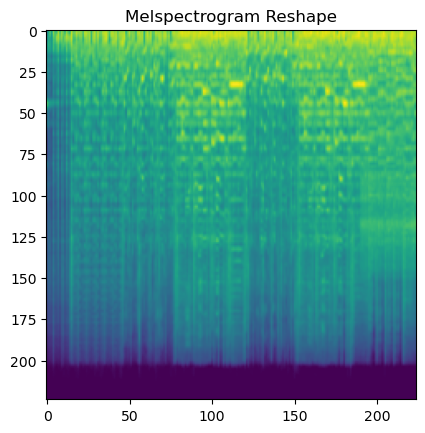

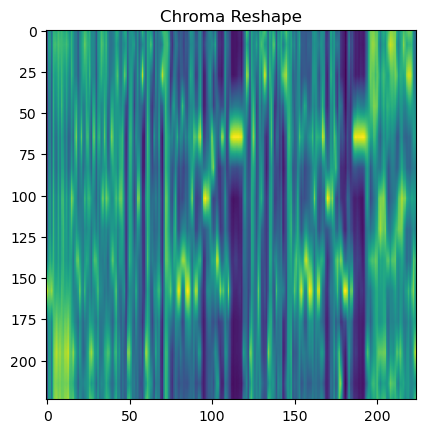

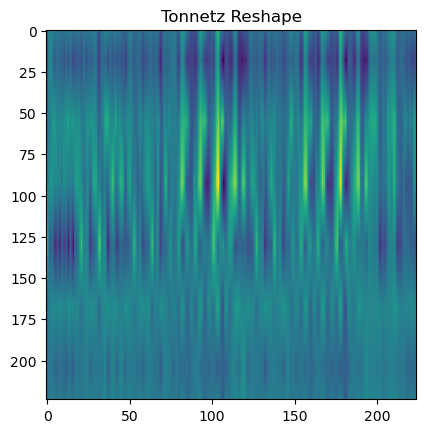

In [32]:
x = np.load("../data/mp3_spectra/cnn_npys/1ZB2qWsheGabSEYvBYxjKn.npy")
plt.figure()
plt.title("Melspectrogram Reshape")
plt.imshow(x[:, :, 0])
plt.figure()
plt.title("Chroma Reshape")
plt.imshow(x[:, :, 1])
plt.figure()
plt.title("Tonnetz Reshape")
plt.imshow(x[:, :, 2])

## Original Output for comparison

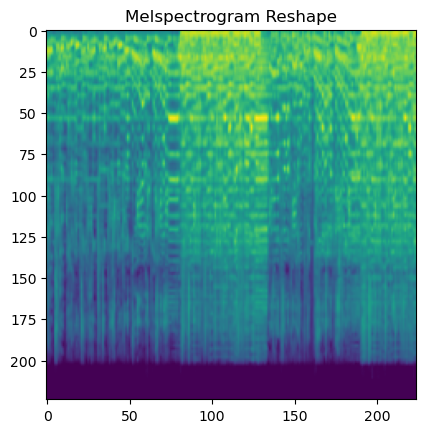

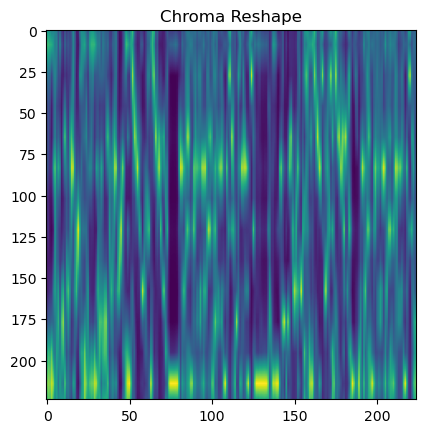

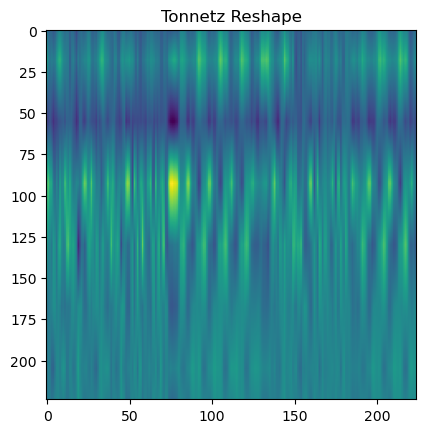

In [13]:
layers = [mel_resize, chroma_resize, tonnetz_resize]
image_stack = []
for layer in layers:
    max_val = layer.max()
    min_val = layer.min()
    range = max_val - min_val
    norm = (layer - min_val) / range
    scaled = norm * 255.999
    as_int = scaled.astype(np.uint8)
    image_stack.append(as_int)
audio_rgb = np.dstack(image_stack)
plt.figure()
plt.title("Melspectrogram Reshape")
plt.imshow(audio_rgb[:, :, 0])
plt.figure()
plt.title("Chroma Reshape")
plt.imshow(audio_rgb[:, :, 1])
plt.figure()
plt.title("Tonnetz Reshape")
plt.imshow(audio_rgb[:, :, 2])

## ResNet50 CNN

In [26]:
def set_random_seed(seed):
    """Random seeds for reproducability"""

    random.seed(seed)
    tf.random.set_seed(seed)

In [27]:
height = 224
width = 224
channels = 3
res_model = ResNet50V2(
    weights="imagenet", include_top=True, input_shape=(height, width, channels)
)
res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [28]:
# Freeze all the layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [29]:
# From Exercise
set_random_seed(121)
res_out = res_model.output

# continue the code here
output = Flatten()(res_out)
# flattened = Flatten()(
#     res_out
# )
# can comment out the dense layers and output since we aren't training
# dense1 = Dense(128, activation="relu")(
#     flattened
# )  # arguments are the result of previous result
# dense2 = Dense(64, activation="relu")(dense1)
# output = Dense(10, activation="softmax")(dense2)

In [30]:
model = Model(inputs=res_model.input, outputs=output)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

(1, 224, 224, 3)

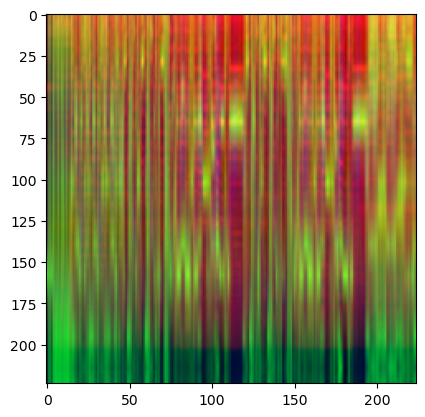

In [33]:
set_random_seed(121)
# model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
weezer = np.load("../data/mp3_spectra/cnn_npys/1ZB2qWsheGabSEYvBYxjKn.npy")
plt.imshow(weezer)
weezer = np.expand_dims(weezer, axis=0)
# add additional dimension upfront since it wants 4 dimensions
weezer.shape

In [35]:
model.predict(weezer)  # forward pass
# Could include this embedding into above loop
# this produces an embedding
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
# early_stop = EarlyStopping(monitor='val_loss',
#                            patience=2, # if two epochs go by without change, then end
#                            mode='min',
#                            verbose=1)
# model.fit(train_generator,
#           epochs=10,
#           validation_data = validation_generator,
#           callbacks=[early_stop])
weezer_array = model.predict(weezer)

1/1 [==============================] - 0s 43ms/step


In [36]:
weezer_array.shape

(1, 1000)

In [ ]:
# Now you can rerun the pairwise similarity again
# Rerun np.argsort